In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import logging
from tqdm import tqdm
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s: %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)

class COVIDSentiDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True
        )
        
        return {
            'input_ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(inputs['token_type_ids'], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

def train_model(model, train_loader, val_loader, optimizer, device, class_weights=None, epochs=5):
    # Detailed logging of class weights
    if class_weights is not None:
        logger.info("Class Weights: %s", class_weights)
    
    # Create loss function with class weights
    if class_weights is not None:
        class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
    else:
        criterion = nn.CrossEntropyLoss()
    
    # Tracking metrics
    best_val_accuracy = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(epochs):
        logger.info(f"Starting Epoch {epoch+1}/{epochs}")
        
        # Training Phase
        model.train()
        total_train_loss = 0
        train_preds, train_true = [], []
        
        # Progress bar for training
        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1} Training", unit="batch")
        for batch in train_progress:
            optimizer.zero_grad()
            
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(
                input_ids, 
                attention_mask=attention_mask, 
                token_type_ids=token_type_ids
            )
            
            # Calculate loss
            loss = criterion(outputs.logits, labels)
            total_train_loss += loss.item()
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Collect predictions
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            train_preds.extend(preds)
            train_true.extend(labels.cpu().numpy())
            
            # Update progress bar
            train_progress.set_postfix({
                'loss': loss.item(), 
                'batch_accuracy': accuracy_score(labels.cpu().numpy(), preds)
            })
        
        # Validation Phase
        model.eval()
        total_val_loss = 0
        val_preds, val_true = [], []
        
        # Progress bar for validation
        val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1} Validation", unit="batch")
        with torch.no_grad():
            for batch in val_progress:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                token_type_ids = batch['token_type_ids'].to(device)
                labels = batch['labels'].to(device)
                
                # Forward pass
                outputs = model(
                    input_ids, 
                    attention_mask=attention_mask, 
                    token_type_ids=token_type_ids
                )
                
                # Calculate loss
                loss = criterion(outputs.logits, labels)
                total_val_loss += loss.item()
                
                # Collect predictions
                preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
                val_preds.extend(preds)
                val_true.extend(labels.cpu().numpy())
                
                # Update progress bar
                val_progress.set_postfix({
                    'loss': loss.item(), 
                    'batch_accuracy': accuracy_score(labels.cpu().numpy(), preds)
                })
        
        # Calculate epoch metrics
        train_loss = total_train_loss / len(train_loader)
        val_loss = total_val_loss / len(val_loader)
        train_accuracy = accuracy_score(train_true, train_preds)
        val_accuracy = accuracy_score(val_true, val_preds)
        
        # Log epoch results
        logger.info(f"Epoch {epoch+1} Summary:")
        logger.info(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        logger.info(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        # Save best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_bert_model.pth')
            logger.info("Saved new best model")
    
    return train_losses, val_losses, train_accuracies, val_accuracies

In [3]:
def main():
    # Set up logging for the entire script
    logger.info("Starting COVID Sentiment Classification")
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f"Using device: {device}")
    
    # Load data
    logger.info("Loading dataset...")
    df = pd.read_csv('COVIDSenti-main/COVIDSenti.csv')
    
    # Encode labels
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
    
    # Log class distribution
    class_distribution = df['label'].value_counts()
    logger.info("Class Distribution:\n%s", class_distribution)
    
    # First split: separate test set
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        df['tweet'], df['label'], 
        test_size=0.15,  # 15% for test set 
        stratify=df['label'], 
        random_state=42
    )
    
    # Second split: separate train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, 
        test_size=0.2,  # 20% of remaining data for validation
        stratify=y_train_val, 
        random_state=42
    )
    
    # Log split information
    logger.info(f"Train set size: {len(X_train)}")
    logger.info(f"Validation set size: {len(X_val)}")
    logger.info(f"Test set size: {len(X_test)}")
    
    # Calculate class weights based on training data
    total_train_samples = len(X_train)
    train_class_distribution = pd.Series(y_train).value_counts()
    class_weights = [total_train_samples / (len(train_class_distribution) * count) 
                     for count in train_class_distribution]
    
    # Prepare tokenizer and model
    logger.info("Preparing tokenizer and model...")
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased', 
        num_labels=len(class_distribution)
    ).to(device)
    
    # Prepare datasets
    train_dataset = COVIDSentiDataset(
        texts=X_train.values, 
        labels=y_train.values, 
        tokenizer=tokenizer, 
        max_len=128
    )
    val_dataset = COVIDSentiDataset(
        texts=X_val.values, 
        labels=y_val.values, 
        tokenizer=tokenizer, 
        max_len=128
    )
    test_dataset = COVIDSentiDataset(
        texts=X_test.values, 
        labels=y_test.values, 
        tokenizer=tokenizer, 
        max_len=128
    )
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Optimizer
    optimizer = AdamW(model.parameters(), lr=2e-5)
    
    # Train the model
    logger.info("Starting model training...")
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, optimizer, device, class_weights
    )
    
    # Plot training metrics
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    logger.info("Training metrics plot saved to 'training_metrics.png'")
    
    # Final evaluation on test set
    logger.info("Loading best model for final test evaluation...")
    model.load_state_dict(torch.load('best_bert_model.pth'))
    model.eval()
    test_preds, test_true = [], []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Test Evaluation", unit="batch"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids, 
                attention_mask=attention_mask, 
                token_type_ids=token_type_ids
            )
            
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            test_preds.extend(preds)
            test_true.extend(labels.cpu().numpy())
    
    # Print test classification report
    test_report = classification_report(
        test_true, 
        test_preds, 
        target_names=label_encoder.classes_
    )
    logger.info("Final Test Classification Report:\n%s", test_report)
    
    logger.info("Training and testing complete!")

2025-03-05 19:13:26 - INFO: Starting COVID Sentiment Classification
2025-03-05 19:13:26 - INFO: Using device: cuda
2025-03-05 19:13:26 - INFO: Loading dataset...
2025-03-05 19:13:26 - INFO: Class Distribution:
label
1    67385
0    16335
2     6280
Name: count, dtype: int64
2025-03-05 19:13:26 - INFO: Train set size: 61200
2025-03-05 19:13:26 - INFO: Validation set size: 15300
2025-03-05 19:13:26 - INFO: Test set size: 13500
2025-03-05 19:13:26 - INFO: Preparing tokenizer and model...
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\udayj\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyT

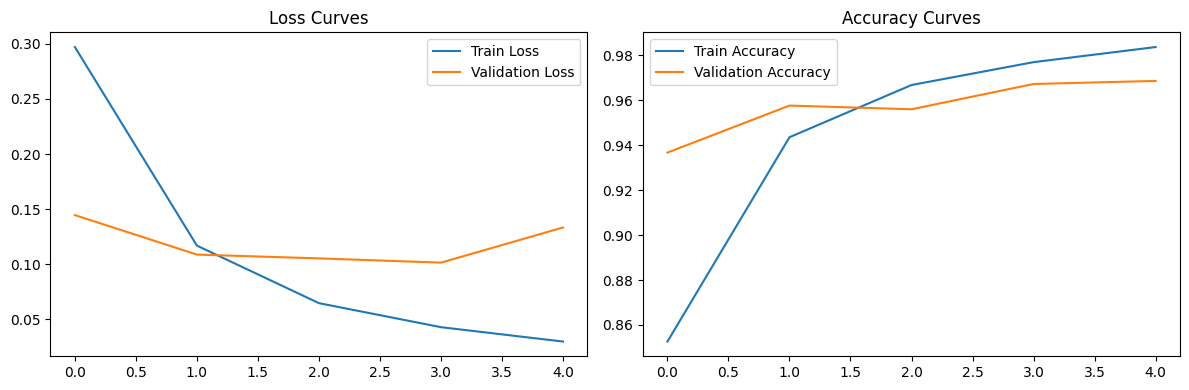

In [4]:
if __name__ == '__main__':
    main()